# Distinguish Demo Notebook

This interactive notebook demonstrates training and evaluation of the `distinguish` binary classifier that separates real photographs from AI-generated synthetic images.

We will:
1. Inspect dataset splits (train / valid / test)
2. Build a pretrained ResNet18 backbone adapted for binary classification
3. Train for a few epochs (configurable) with metric tracking
4. Visualize training curves (loss, accuracy, precision, recall, F1)
5. Evaluate on the test set (confusion matrix, metrics)
6. Show sample predictions
7. Summarize performance & save final model weights

> NOTE: The full dataset (140k images) is large; for faster experimentation you can enable a FAST_MODE that subsamples each split.


In [1]:
# 1. Imports & Configuration
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from distinguish import build_model, DistinguishDataset
from distinguish.data import default_transforms
from distinguish.train import Trainer, TrainerConfig
from distinguish.utils import get_device, compute_binary_metrics
from distinguish.io import save_model, load_model

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

DEVICE = get_device()
FAST_MODE = bool(
    int(os.environ.get("DISTINGUISH_FAST", "0"))
)  # set DISTINGUISH_FAST=1 for subset runs
SUBSET_PER_CLASS = 2000  # only used in FAST_MODE
EPOCHS = 3 if FAST_MODE else 5
BATCH_SIZE = 32
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print(f"Device: {DEVICE}")
print(f"FAST_MODE: {FAST_MODE}")

Device: cpu
FAST_MODE: False


## 2. Load Dataset & Basic Exploration

In [ ]:
# Resolve dataset root robustly
def find_dataset_root():
    candidates = [
        Path("datasets/faces"),  # relative to root
        Path.cwd() / "datasets/faces",  # relative to current working dir
        Path.cwd().parent
        / "datasets/faces",  # relative to parent (e.g. if cwd is examples/)
    ]
    for c in candidates:
        if c.exists():
            return c
    raise FileNotFoundError(
        "Could not locate faces dataset. Tried: "
        + ", ".join(str(c) for c in candidates)
        + f" (cwd={Path.cwd()})"
    )


DATA_ROOT = find_dataset_root()
print(f"Using DATA_ROOT: {DATA_ROOT}")
TRAIN_DIR = DATA_ROOT / "train"
VALID_DIR = DATA_ROOT / "valid"
TEST_DIR = DATA_ROOT / "test"

train_ds_full = DistinguishDataset(
    str(TRAIN_DIR),
    transform=default_transforms(train=True),
    labelmap={"real": 1, "fake": 0, "ai_generated": 0},
)
valid_ds_full = DistinguishDataset(
    str(VALID_DIR),
    transform=default_transforms(train=False),
    labelmap={"real": 1, "fake": 0, "ai_generated": 0},
)
test_ds_full = DistinguishDataset(
    str(TEST_DIR),
    transform=default_transforms(train=False),
    labelmap={"real": 1, "fake": 0, "ai_generated": 0},
)

# Optional FAST_MODE subsampling
if FAST_MODE:

    def subset(ds, per_class):
        real = [s for s in ds.samples if s[1] == 1][:per_class]
        fake = [s for s in ds.samples if s[1] == 0][:per_class]
        ds.samples = real + fake
        random.shuffle(ds.samples)

    subset(train_ds_full, SUBSET_PER_CLASS)
    subset(valid_ds_full, SUBSET_PER_CLASS // 5)
    subset(test_ds_full, SUBSET_PER_CLASS // 5)

print(
    f"Train samples: {len(train_ds_full)} | Valid: {len(valid_ds_full)} | Test: {len(test_ds_full)}"
)

splits = {"Train": train_ds_full, "Valid": valid_ds_full, "Test": test_ds_full}
rows = []
for name, ds in splits.items():
    real = sum(1 for _, lbl in ds.samples if lbl == 1)
    fake = sum(1 for _, lbl in ds.samples if lbl == 0)
    rows.append({"Split": name, "Real": real, "Fake": fake, "Total": len(ds)})
stat_df = pd.DataFrame(rows)
stat_df

Using DATA_ROOT: datasets\faces
Train samples: 100000 | Valid: 20000 | Test: 20000


,Split,Real,Fake,Total
0,Train,50000,50000,100000
1,Valid,10000,10000,20000
2,Test,10000,10000,20000


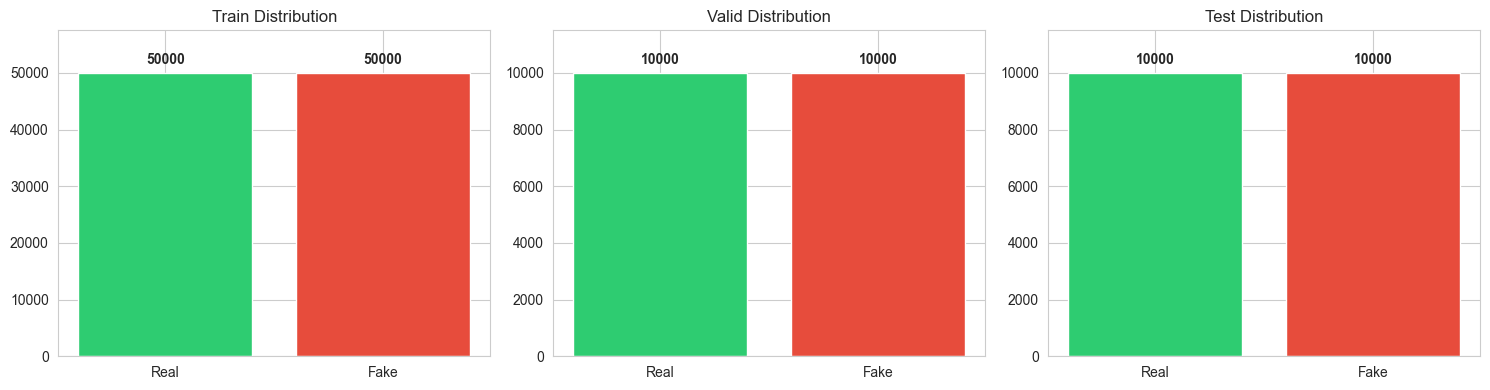

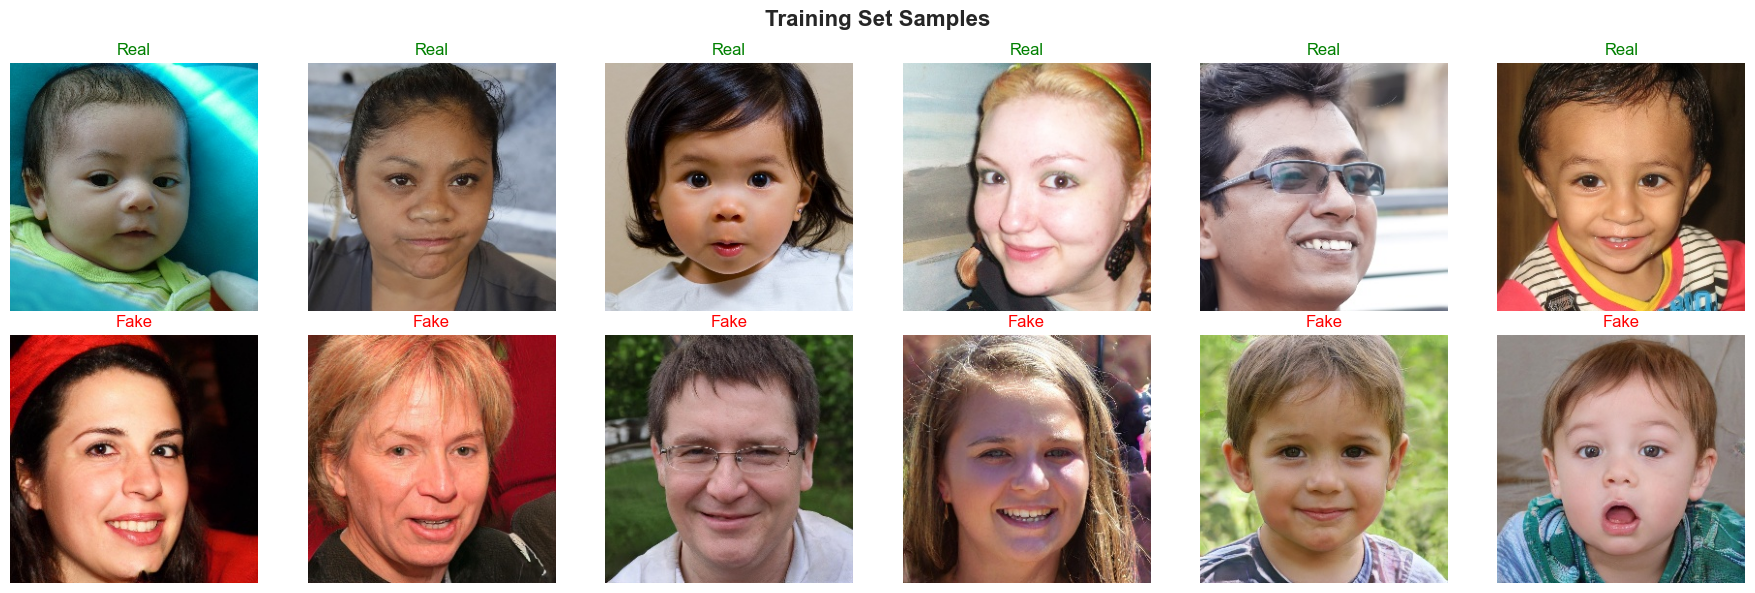

In [ ]:
# Bar plots per split
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, ds) in zip(axes, splits.items()):
    real = sum(1 for _, lbl in ds.samples if lbl == 1)
    fake = sum(1 for _, lbl in ds.samples if lbl == 0)
    ax.bar(["Real", "Fake"], [real, fake], color=["#2ecc71", "#e74c3c"])
    ax.set_title(f"{name} Distribution")
    ax.set_ylim(0, max(real, fake) * 1.15)
    for i, val in enumerate([real, fake]):
        ax.text(
            i,
            val + 0.02 * val,
            str(val),
            ha="center",
            va="bottom",
            fontweight="bold",
        )
plt.tight_layout()
plt.show()

# Sample image grid
SAMPLE_PER_CLASS = 6
real_samples = [s for s in train_ds_full.samples if s[1] == 1][:SAMPLE_PER_CLASS]
fake_samples = [s for s in train_ds_full.samples if s[1] == 0][:SAMPLE_PER_CLASS]
fig, axes = plt.subplots(2, SAMPLE_PER_CLASS, figsize=(3 * SAMPLE_PER_CLASS, 6))
for i, (path, _) in enumerate(real_samples):
    img = Image.open(path).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Real", color="green")
for i, (path, _) in enumerate(fake_samples):
    img = Image.open(path).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].axis("off")
    axes[1, i].set_title("Fake", color="red")
fig.suptitle("Training Set Samples", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

## 3. Build Model (ResNet18)

In [4]:
model = build_model(backbone="resnet18", pretrained=True)
print(model.__class__.__name__, "loaded.")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print(f"Frozen params: {total_params - trainable_params:,}")

model.to(DEVICE)

ResNet loaded.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(i

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4. Data Loaders

In [5]:
train_loader = DataLoader(
    train_ds_full,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)
valid_loader = DataLoader(
    valid_ds_full,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)
test_loader = DataLoader(
    test_ds_full,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
)

len(train_loader), len(valid_loader), len(test_loader)

(3125, 625, 625)

## 5. Train Model

In [6]:
config = TrainerConfig(
    lr=1e-4,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    weight_decay=1e-4,
    optimizer="adam",
    mixed_precision=False,
    out_dir="runs/demo",
    seed=RANDOM_SEED,
)
trainer = Trainer(model, device=DEVICE, config=config)
result = trainer.train(train_loader, valid_loader)
result["best_metric"]

Epoch 5/5: 100%|██████████| 3125/3125 [1:21:58<00:00,  1.57s/it, loss=0.0012]


0.9936

## 6. Training History & Curves

In [7]:
metrics_path = Path("runs/demo/metrics.csv")
if metrics_path.exists():
    history_df = pd.read_csv(metrics_path)
else:
    history_df = pd.DataFrame(result["history"])

history_df.head()

,epoch,train_loss,train_accuracy,train_precision,train_recall,train_f1,val_accuracy,val_precision,val_recall,val_f1
0,1,0.098036,0.96131,0.961098,0.96154,0.961319,0.98340,0.970875,0.9967,0.983618
1,2,0.033027,0.98834,0.988555,0.98812,0.988337,0.99100,0.993467,0.9885,0.990977
2,3,0.023016,0.99197,0.992275,0.99166,0.991968,0.99330,0.995281,0.9913,0.993287
3,4,0.018697,0.99321,0.993161,0.99326,0.993210,0.99360,0.995582,0.9916,0.993587
4,5,0.015468,0.99449,0.994916,0.99406,0.994488,0.99335,0.988224,0.9986,0.993385


C:\Users\edwardyliu\AppData\Local\Temp\ipykernel_6456\2452093681.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


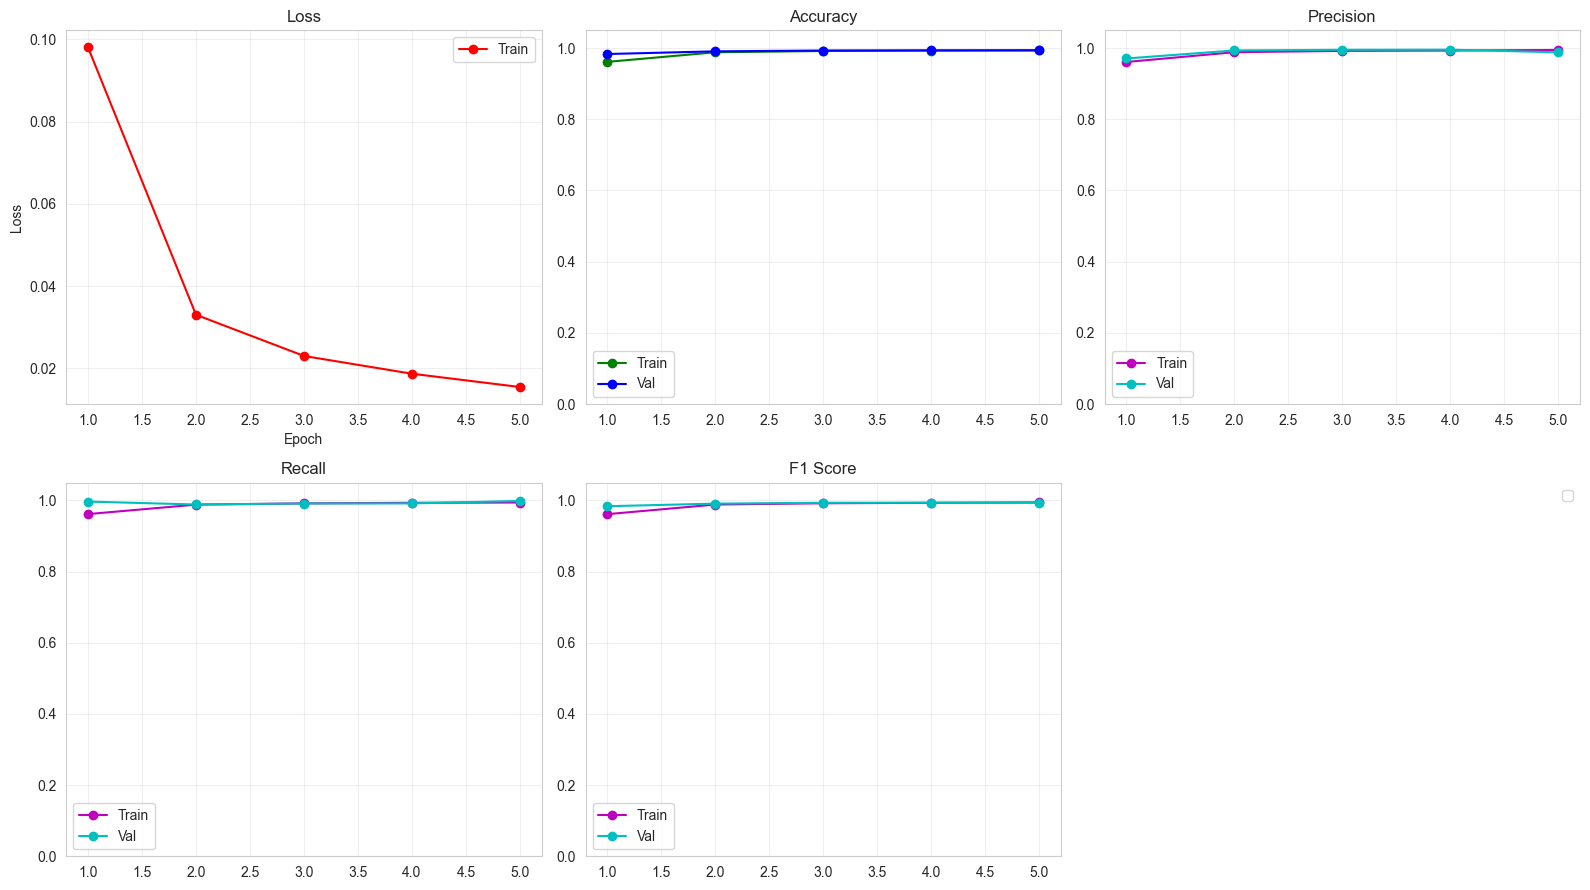

In [8]:
# Plot curves
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
metrics_map = {
    "train_loss": ("Train Loss", 0),
    "train_accuracy": ("Train Acc", 1),
    "val_accuracy": ("Val Acc", 1),
    "train_precision": ("Train Precision", 2),
    "val_precision": ("Val Precision", 2),
    "train_recall": ("Train Recall", 3),
    "val_recall": ("Val Recall", 3),
    "train_f1": ("Train F1", 4),
    "val_f1": ("Val F1", 4),
}
# Loss
axes[0, 0].plot(history_df["epoch"], history_df["train_loss"], "o-r", label="Train")
axes[0, 0].set_title("Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Loss")
# Accuracy
axes[0, 1].plot(history_df["epoch"], history_df["train_accuracy"], "o-g", label="Train")
axes[0, 1].plot(history_df["epoch"], history_df["val_accuracy"], "o-b", label="Val")
axes[0, 1].set_title("Accuracy")
axes[0, 1].set_ylim(0, 1.05)
# Precision
axes[0, 2].plot(
    history_df["epoch"], history_df["train_precision"], "o-m", label="Train"
)
axes[0, 2].plot(history_df["epoch"], history_df["val_precision"], "o-c", label="Val")
axes[0, 2].set_title("Precision")
axes[0, 2].set_ylim(0, 1.05)
# Recall
axes[1, 0].plot(history_df["epoch"], history_df["train_recall"], "o-m", label="Train")
axes[1, 0].plot(history_df["epoch"], history_df["val_recall"], "o-c", label="Val")
axes[1, 0].set_title("Recall")
axes[1, 0].set_ylim(0, 1.05)
# F1
axes[1, 1].plot(history_df["epoch"], history_df["train_f1"], "o-m", label="Train")
axes[1, 1].plot(history_df["epoch"], history_df["val_f1"], "o-c", label="Val")
axes[1, 1].set_title("F1 Score")
axes[1, 1].set_ylim(0, 1.05)
# Blank remove last axis
axes[1, 2].axis("off")
for ax in axes.flat:
    ax.grid(alpha=0.3)
    ax.legend()
plt.tight_layout()
plt.show()

## 7. Evaluate on Test Set

In [9]:
# Load best checkpointed model
best_weights = Path("runs/demo/best_model.pt")
if best_weights.exists():
    load_model(model, str(best_weights))

model.eval()
with torch.no_grad():
    preds = []
    targets = []
    for images, labels in tqdm(test_loader, desc="Test Eval"):
        images = images.to(DEVICE)
        logits = model(images).view(-1)
        preds.append(logits.cpu())
        targets.append(labels.cpu())
logits = torch.cat(preds)
labels = torch.cat(targets)
metrics = compute_binary_metrics(logits, labels)
metrics

Test Eval: 100%|██████████| 625/625 [06:45<00:00,  1.54it/s]


{'accuracy': 0.99305,
 'precision': 0.9957767722473605,
 'recall': 0.9903,
 'f1': 0.9930308347956881}

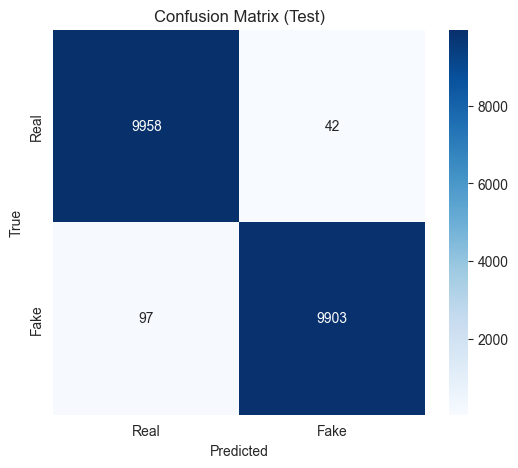

array([[9958,   42],
       [  97, 9903]])

In [10]:
# Plot confusion matrix
probs = torch.sigmoid(logits)
pred_labels = (probs >= 0.5).float()
cm = confusion_matrix(labels.numpy(), pred_labels.numpy())

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Real", "Fake"],
    yticklabels=["Real", "Fake"],
)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix (Test)")
plt.show()

cm

## 8. Sample Predictions

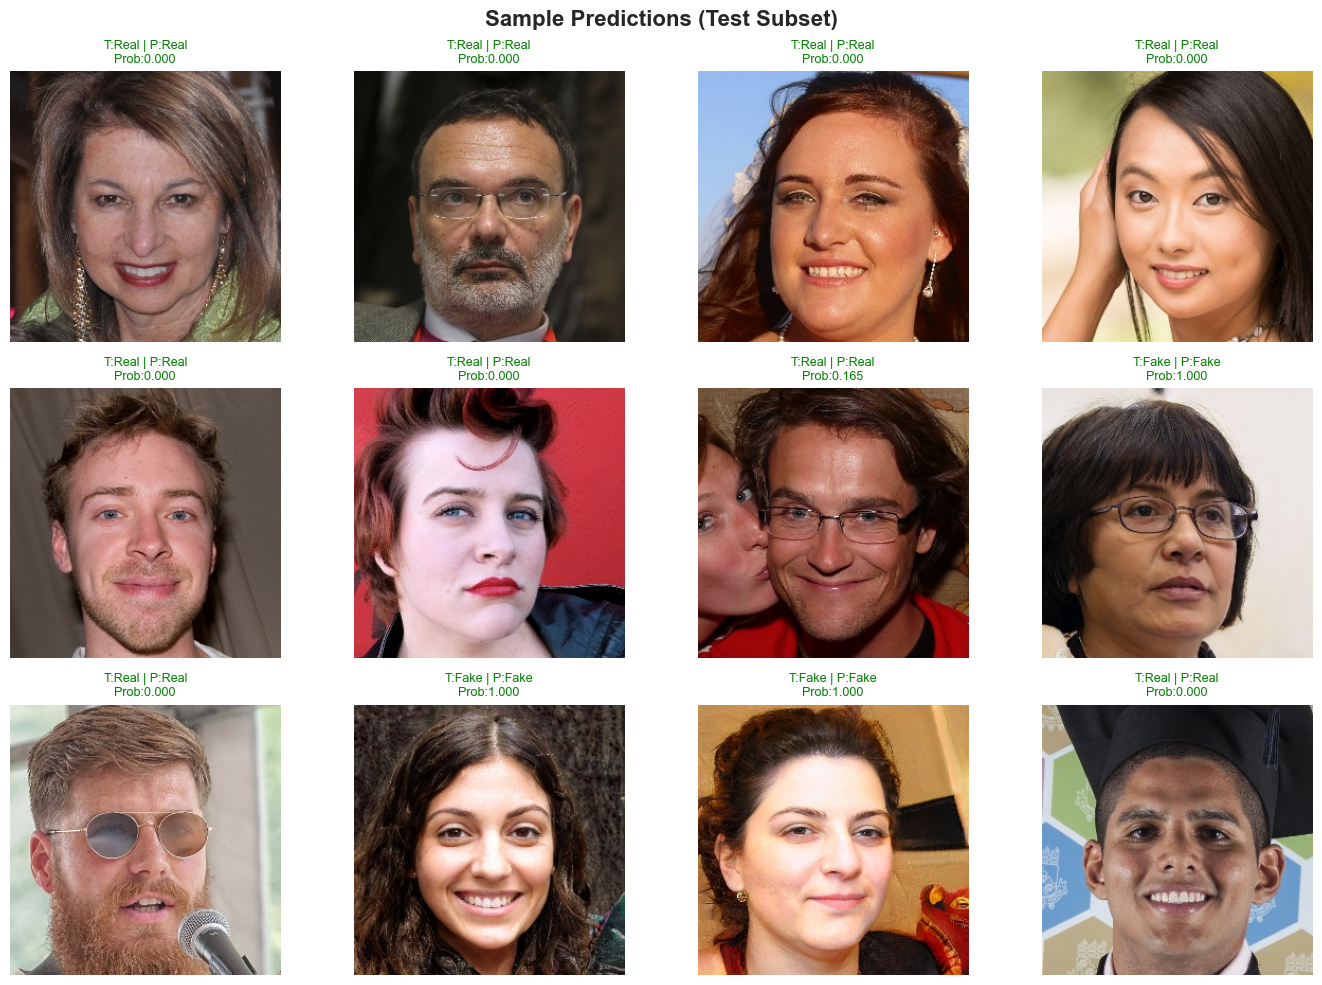

In [ ]:
random.seed(RANDOM_SEED)
SAMPLES = 12
indices = random.sample(range(len(test_ds_full)), SAMPLES)
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
model.eval()
with torch.no_grad():
    for i, idx in enumerate(indices):
        path, true_label = test_ds_full.samples[idx]
        img = Image.open(path).convert("RGB")
        tensor, _ = test_ds_full[idx]
        tensor = tensor.unsqueeze(0).to(DEVICE)
        logit = model(tensor).view(-1)[0]
        prob = torch.sigmoid(logit).item()
        pred_label = 1 if prob >= 0.5 else 0
        r = i // 4
        c = i % 4
        axes[r, c].imshow(img)
        axes[r, c].axis("off")
        true_name = "Real" if true_label == 1 else "Fake"
        pred_name = "Real" if pred_label == 1 else "Fake"
        color = "green" if pred_label == true_label else "red"
        axes[r, c].set_title(
            f"T:{true_name} | P:{pred_name}\nProb:{prob:.3f}", color=color, fontsize=9
        )
plt.suptitle("Sample Predictions (Test Subset)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

## 9. Performance Summary

In [12]:
final_epoch = history_df.iloc[-1]
train_metrics = {
    "Accuracy": final_epoch["train_accuracy"],
    "Precision": final_epoch["train_precision"],
    "Recall": final_epoch["train_recall"],
    "F1": final_epoch["train_f1"],
}
val_metrics = {
    "Accuracy": final_epoch["val_accuracy"],
    "Precision": final_epoch["val_precision"],
    "Recall": final_epoch["val_recall"],
    "F1": final_epoch["val_f1"],
}

# Test metrics already computed
comparison = pd.DataFrame(
    {
        "Train": train_metrics,
        "Validation": val_metrics,
        "Test": {
            "Accuracy": metrics["accuracy"],
            "Precision": metrics["precision"],
            "Recall": metrics["recall"],
            "F1": metrics["f1"],
        },
    }
).T
comparison

,Accuracy,Precision,Recall,F1
Train,0.99449,0.994916,0.99406,0.994488
Validation,0.99335,0.988224,0.99860,0.993385
Test,0.99305,0.995777,0.99030,0.993031


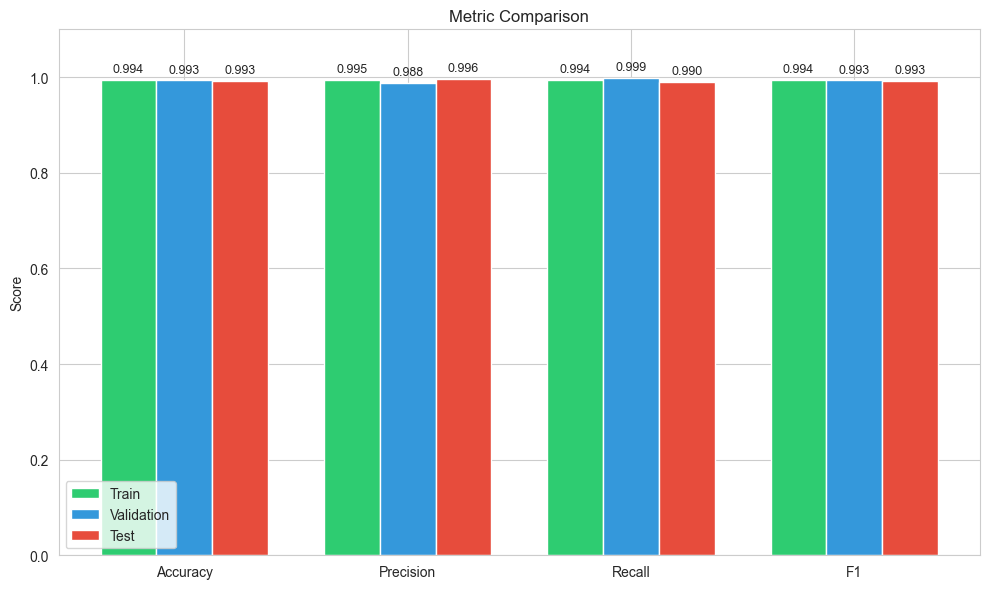

In [13]:
# Bar comparison
metrics_list = ["Accuracy", "Precision", "Recall", "F1"]
x = np.arange(len(metrics_list))
width = 0.25
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(
    x - width,
    [train_metrics[m] for m in metrics_list],
    width,
    label="Train",
    color="#2ecc71",
)
bar2 = ax.bar(
    x,
    [val_metrics[m] for m in metrics_list],
    width,
    label="Validation",
    color="#3498db",
)
bar3 = ax.bar(
    x + width,
    [metrics[m.lower()] for m in metrics_list],
    width,
    label="Test",
    color="#e74c3c",
)
ax.set_xticks(x)
ax.set_xticklabels(metrics_list)
ax.set_ylim(0, 1.1)
ax.set_ylabel("Score")
ax.set_title("Metric Comparison")
ax.legend()
for bars in (bar1, bar2, bar3):
    for b in bars:
        ax.text(
            b.get_x() + b.get_width() / 2,
            b.get_height() + 0.01,
            f"{b.get_height():.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )
plt.tight_layout()
plt.show()

## 10. Save Final Model & Wrap Up

In [ ]:
final_path = Path("models")
final_path.mkdir(exist_ok=True)
final_weights = final_path / "resnet18_alt.pt"
save_model(model, str(final_weights))
print(f"Saved final weights to {final_weights}")
print("Notebook run complete ✔")

Saved final weights to models\resnet18.pt
Notebook run complete ✔
